# Breast Cancer Dataset

## Data Exploration

In [1]:
'''Importing Required libraries'''
import numpy as np
import pandas as pd
from statistics import mean
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score,roc_curve, auc
from sklearn.model_selection import GridSearchCV,StratifiedKFold
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load dataset into vairable using pandas read_csv method
dataset = pd.read_csv("CSVs/dataset.csv")
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
# Check whether any column contains any missing values or not. It can be checked by isnull()
# sum() provides data by axis = 0 default
dataset.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [5]:
# As see above, it is clear that unnamed:32 column contains null values, So it is required to remove them
df=dataset.dropna(axis=1)# axis = 1 indicates column

In [6]:
#label encoder is method which is used to convert categorical data into numerical data
#As our dataset contains only 
target = LabelEncoder().fit_transform(df.iloc[:,1].values)# Second column (column =1) is the ouput class
features = df.iloc[:,2:31].values # Third Column to last column are the feature vectors

## Hyperparameter Tuning

Hyperparameters are the parameters which are used to control learning process. In sklearn they are passed as an arguments to the constructor of the estimator classes. Hyperparameter Tuning or optimisation is the process of finding the best optimized or ideal hyperparameters for constructing the classifier. In sklearn, We mainly uses two types of Hyperparameter Optimisations:
 1) GridSearchCV
         2) RandomizedSearchCV

GridSearchCV provides grid search which exhaustively (i.e. using brute force techniques) generates sets of hyperparameters depending upon the parameters specified in param_grid [1]. Among the all generated sets, it selects one set of hyperparameters and trains the model on that particular set of hyperparamter. After training all sets, it provides set of parameter which has the maximum or minimum scoring as defined by the scoring value. For example, In KNN problem, we want to find the best value of neighbors between 5,15. Here, we will define param_grid  = dict(n_neighbors = range(5,16)). Now GridSearchCV will generates search space containing 10 solutions. Among them it will decide which is best according to scoring value i.e. accuracy, precision, roc and many more.

In contrast, RandomizedSearchCV generates random hyperparameters and train classifier over that. But it genearates sets accoriding to number of iteration specified by the user or by default. It selects the best set according to the scoring strategy specified. 

Both uses cross validation for splitting training and testing 

In [7]:
k_range = range(2,51)
weight_options = ['uniform', 'distance'] # Weights are used in predictions for predicting the relevent class
algorithm = ['ball_tree','kd_tree','brute']# These algorithms are used to find the nearest neigbors
param_dist = dict(n_neighbors = k_range, weights = weight_options, algorithm = algorithm)# described in [1] i.e above in second paragraph

In [8]:
'''The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different 
parameters.
Step I is StandardScale, As the dataset contains huge variance among features, so it is neccessary to scale dataset.
Step II includes classifier on which we have to test combinations of paramters
'''
clf = Pipeline([('scaler', StandardScaler()), ('classifier',KNeighborsClassifier())])

In [9]:
'''I am using KFold to generate training and testing examples. It is more efficient than train test split.As our dataset 
contains unequal number of examples for target classes. I am using StratifiedKFold so that each set contains approximately 
the same percentage of samples of each target class as the complete set.'''

strat_k_fold = StratifiedKFold(n_splits=10,random_state=42)# It will create 9 training sets and 1 testing set

param_dist = dict(classifier__n_neighbors = k_range, classifier__weights = weight_options, classifier__algorithm = algorithm)
 
'''I used pipeline so each training test set get scaled in there respective set. As it would make our model to predict better 
on unseened data.'''

grid = GridSearchCV(clf, cv = strat_k_fold, param_grid = param_dist, n_jobs =-1, verbose =2)
grid.fit(features, target)
print('Best Hyperparameters using grid search: \n', grid.best_params_)
print('Scoring : ' ,grid.best_score_)


Fitting 10 folds for each of 294 candidates, totalling 2940 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 2318 tasks      | elapsed:   17.3s


Best Hyperparameters using grid search: 
 {'classifier__algorithm': 'ball_tree', 'classifier__n_neighbors': 15, 'classifier__weights': 'distance'}
Scoring :  0.9701230228471002


[Parallel(n_jobs=-1)]: Done 2940 out of 2940 | elapsed:   23.6s finished


In [10]:
# grid.cv_results_ can be used to look all into the search space.
pd.DataFrame(grid.cv_results_).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__algorithm,param_classifier__n_neighbors,param_classifier__weights,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.007380,0.001680,0.007480,0.002370,ball_tree,2,uniform,"{'classifier__algorithm': 'ball_tree', 'classi...",1.000000,0.913793,...,0.966797,0.966797,0.966797,0.974609,0.972656,0.970760,0.968811,0.970760,0.969928,0.002648
1,0.002593,0.000488,0.002892,0.000698,ball_tree,2,distance,"{'classifier__algorithm': 'ball_tree', 'classi...",0.965517,0.913793,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.002593,0.000661,0.005385,0.000489,ball_tree,3,uniform,"{'classifier__algorithm': 'ball_tree', 'classi...",0.982759,0.948276,...,0.982422,0.982422,0.978516,0.986328,0.984375,0.986355,0.980507,0.980507,0.982229,0.002544
3,0.003192,0.001984,0.003789,0.001985,ball_tree,3,distance,"{'classifier__algorithm': 'ball_tree', 'classi...",0.982759,0.948276,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.002993,0.002676,0.006582,0.001276,ball_tree,4,uniform,"{'classifier__algorithm': 'ball_tree', 'classi...",0.982759,0.948276,...,0.970703,0.970703,0.964844,0.980469,0.974609,0.974659,0.974659,0.972710,0.972073,0.004210
5,0.003191,0.002309,0.002793,0.000399,ball_tree,4,distance,"{'classifier__algorithm': 'ball_tree', 'classi...",0.982759,0.965517,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,0.002194,0.000399,0.005485,0.000499,ball_tree,5,uniform,"{'classifier__algorithm': 'ball_tree', 'classi...",0.982759,0.965517,...,0.982422,0.976562,0.972656,0.982422,0.984375,0.972710,0.978558,0.976608,0.978130,0.003780
7,0.002892,0.001510,0.002892,0.000537,ball_tree,5,distance,"{'classifier__algorithm': 'ball_tree', 'classi...",0.982759,0.965517,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,0.002593,0.000489,0.007081,0.002693,ball_tree,6,uniform,"{'classifier__algorithm': 'ball_tree', 'classi...",0.982759,0.965517,...,0.972656,0.972656,0.966797,0.972656,0.976562,0.972710,0.974659,0.972710,0.972857,0.002384
9,0.002494,0.000669,0.003191,0.000399,ball_tree,6,distance,"{'classifier__algorithm': 'ball_tree', 'classi...",0.982759,0.965517,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [11]:
#store all hyperparameters into dictionary
parameters = grid.best_params_
print(type(parameters))
print(parameters)

<class 'dict'>
{'classifier__algorithm': 'ball_tree', 'classifier__n_neighbors': 15, 'classifier__weights': 'distance'}


In [12]:
classifier = KNeighborsClassifier(n_neighbors = parameters['classifier__n_neighbors'], 
                                  weights = parameters['classifier__weights'], algorithm = parameters['classifier__algorithm'])

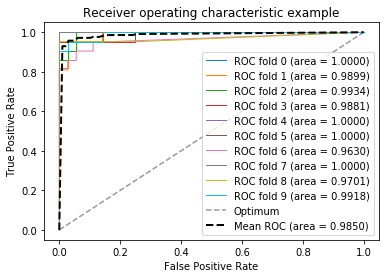

In [13]:
%matplotlib inline
# declaring variables for storing accuracy, precision, recall , f1 in each fold
accuracy = []
precision = []
recall = []
f1 = []
Auc = []
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
i=0 

scaler = StandardScaler()# to scale the features to have 0 mean and 1 variance.

# split function is used to split the k-1 training and 1 testing fold.
for train, test in strat_k_fold.split(features, target):
    #scale the training and example set by StandardScaler
    features[train] = scaler.fit_transform(features[train])
    features[test] = scaler.fit_transform(features[test])
    # fitting the classifier model
    classifier.fit(features[train], target[train])
    
    prob = classifier.predict_proba(features[test])# it returns the predicted probabilities
    pred = classifier.predict(features[test])# predict classes
    
    #append the scores into respective lists as declared above
    accuracy.append(accuracy_score(target[test], pred))
    precision.append(precision_score(target[test], pred))
    recall.append(recall_score(target[test], pred))
    f1.append(f1_score(target[test], pred))
    
    ''' Compute ROC curve and area the curve. It is plotted between
        >> ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model 
        at all classification thresholds
        >> AUC (Area under the curve) tells how effectively our model is distinguishing between the curves.
    '''
    # roc_curve is a method which returns false positive rate, true positive rate and thresholds on the basis of target and 
    # predicted probabilities
    
    fpr, tpr, thresholds = roc_curve(target[test], prob[:,1])
    # interp is the process of adding parameter between the points and it returns 1d array
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)#area under the curve
    Auc.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.4f)' % (i, roc_auc))
    i=i+1

plt.plot([0, 1], [0, 1], '--', color=(0.6,0.6,0.6), label='Optimum')
# calculating mean
mean_tpr /=  strat_k_fold.get_n_splits(features, target)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.4f)' % mean_auc, lw=2)# ploting mean curve
# setting limits of x axix and y axis
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

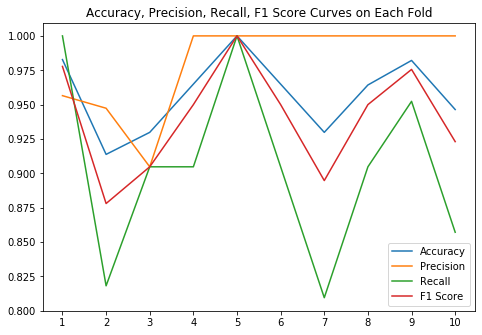

In [14]:
%matplotlib inline
x = np.arange(1,11)
fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.plot(x,accuracy, label ='Accuracy')
ax.plot(x,precision, label = 'Precision')
ax.plot(x,recall,label = 'Recall')
ax.plot(x,f1, label = 'F1 Score')
ax.legend(loc = 'best')
plt.xticks(x)
plt.title('Accuracy, Precision, Recall, F1 Score Curves on Each Fold')
plt.show()

In [15]:
accuracy = [round(i*100,2) for i in accuracy]
precision = [round(j*100,2) for j in precision]
f1 = [round(k*100,2) for k in f1]
recall = [round(l*100,2) for l in recall]
results = np.array([accuracy, precision, recall, f1, Auc])
results = results.transpose()
print(accuracy)

[98.28, 91.38, 92.98, 96.49, 100.0, 96.49, 92.98, 96.43, 98.21, 94.64]


In [16]:
columns = ['Accuracy (%)', 'Precision (%)','F1 Score (%)', 'Recall (%)', 'Area Under the Curve']
index = ['Fold 0','Fold 1','Fold 2','Fold 3', 'Fold 4', 'Fold 5','Fold 6','Fold 7','Fold 8', 'Fold 9']
resultant_dataframe = pd.DataFrame(results, columns = columns ,index = index)
resultant_dataframe.loc['Mean'] = resultant_dataframe.mean(numeric_only=True, axis=0)

In [17]:
resultant_dataframe

,Accuracy (%),Precision (%),F1 Score (%),Recall (%),Area Under the Curve
Fold 0,98.280,95.650,100.000,97.78,1.000000
Fold 1,91.380,94.740,81.820,87.80,0.989899
Fold 2,92.980,90.480,90.480,90.48,0.993386
Fold 3,96.490,100.000,90.480,95.00,0.988095
Fold 4,100.000,100.000,100.000,100.00,1.000000
Fold 5,96.490,100.000,90.480,95.00,1.000000
Fold 6,92.980,100.000,80.950,89.47,0.962963
Fold 7,96.430,100.000,90.480,95.00,1.000000
Fold 8,98.210,100.000,95.240,97.56,0.970068
Fold 9,94.640,100.000,85.710,92.31,0.991837


### Exporting Results to CSV

In [18]:
data = pd.DataFrame( columns = columns)
data.loc['KNN'] = pd.Series( resultant_dataframe.loc['Mean'], index = columns)

In [19]:
data

,Accuracy (%),Precision (%),F1 Score (%),Recall (%),Area Under the Curve
KNN,95.788,98.087,90.564,94.04,0.989625


In [20]:
data.to_csv('CSVs/stats.csv',mode = 'a',header=False)

In [21]:
p = pd.read_csv('CSVs/stats.csv')
p.head()

,Classifier,Accuracy (%),Precision (%),F1 Score (%),Recall (%),Area Under the Curve
0,KNN,95.788,98.087,90.564,94.04,0.989625
